In [1]:
import json
from urllib.request import urlopen
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def column(matrix, i):
    return [row[i] for row in matrix]

def get_jsonparsed_data(projectId):
    response = requests.get("https://tasks.hotosm.org/api/v1/project/" + str(projectId))
    return response.json()

# Extract info from json

In [2]:
def get_jsonparsed_data(projectId):
    response = requests.get("https://tasks.hotosm.org/api/v1/project/" + str(projectId))
    return response.json()

def read_jsonfile_data(fileName):
    with open(fileName) as f:
        data = json.load(f)
    return data    
    
projects = []
project_json = read_jsonfile_data("data/project.json")

In [3]:
result = pd.DataFrame(columns=['ProjectId', 'TaskId', 'TaskStatus', 'Coordinates'])

In [4]:
validated_percent = {}

In [ ]:
for key,value in enumerate(project_json['mapResults']['features']):
    projects.append(value['properties']['projectId'])
    
for projectId in projects:
    val = 0
    task_json = get_jsonparsed_data(projectId)
    for task in task_json['tasks']['features']:
        #result = result.append({'ProjectId' : projectId,
        #               'TaskId' : task['properties']['taskId'],
        #               'TaskStatus' : task['properties']['taskStatus'],
        #               'Coordinates' : task['geometry']['coordinates']}, ignore_index = True)
        if task['properties']['taskStatus'] == "VALIDATED":
            val += 1
    validated_percent[projectId] = val / len(task_json['tasks']['features'])  
    #

In [51]:
np.set_printoptions(precision=0,suppress=True) 
final =  [int(k) for k, v in validated_percent.items() if v > 0.90]

In [52]:
final_1 = [int(k) for k, v in validated_percent.items() if v == 1]

In [53]:
# a = np.asarray(final_1)
# np.savetxt("output/project_100b.csv", a, delimiter=",")

In [54]:
# a = np.asarray(final)
# np.savetxt("output/project_90b.csv", a, delimiter=",")

# Coords of projects

In [23]:
# list of # of projects that are 100% validated
final_1 = pd.read_csv("output/project_100.csv", header=None, dtype=int)

In [24]:
def coords_of_projects(projects):
    coords = []
    for i, projectId in enumerate(projects):
        if i in [i for i in range(0, len(projects), 50)]:
            print("Parsed: %0.1f / 100" % (i / len(projects) * 100))
        task_json = get_jsonparsed_data(projectId)
        coords.append(task_json['areaOfInterest']['coordinates'][0][0])
        
    return coords

In [25]:
coords_list = coords_of_projects(final_1[0])

Parsed: 0.0 / 100
Parsed: 25.8 / 100
Parsed: 51.5 / 100
Parsed: 77.3 / 100


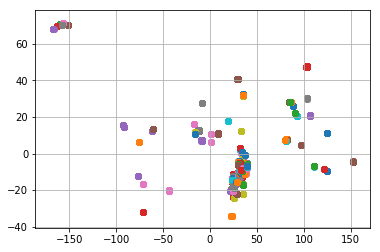

In [26]:
for coords in coords_list:
    plt.scatter(column(coords, 0), column(coords, 1))
plt.grid()

In [27]:
def bounding_boxes_from_coords(coords_list):
    bounding_boxes = []
    for coords in coords_list:
        x_min, x_max = min(column(coords, 0)), max(column(coords, 0))
        y_min, y_max = min(column(coords, 1)), max(column(coords, 1))
        # not [xmin, ymin, xmax, ymax]
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    return bounding_boxes

In [28]:
bounding_boxes_list = bounding_boxes_from_coords(coords_list)

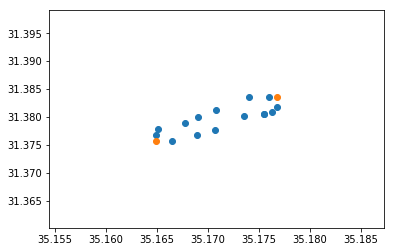

In [48]:
i = 45
coords = coords_list[i]
bounding_boxes = bounding_boxes_list[i]

plt.scatter(column(coords_list[i], 0), column(coords_list[i], 1))
plt.scatter([bounding_boxes[0], bounding_boxes[2]], 
            [bounding_boxes[1], bounding_boxes[3]])

In [32]:
from geopy.geocoders import Nominatim

def countries_from_bounding_boxes(bounding_boxes_list):
    geolocator = Nominatim()
    countries_list = []
    for bb in bounding_boxes_list:
        location1 = geolocator.reverse([bb[1], bb[0]], language='en')
#         location2 = geolocator.reverse(bb[2:4], language='en')
        countries_list.append(location1.address.split(',')[-1].lower()[1:])
    return countries_list


In [33]:
countries_list = countries_from_bounding_boxes(bounding_boxes_list)

In [37]:
project_ids = final_1[0]

In [38]:
data = pd.DataFrame({'id' : project_ids,
              'country' : countries_list,
              'coord_1': column(bounding_boxes_list, 0),
              'coord_2': column(bounding_boxes_list, 1),
              'coord_3': column(bounding_boxes_list, 2),
              'coord_4': column(bounding_boxes_list, 3)})

In [40]:
# data.to_csv('output/data_100validated.csv', float_format='%.15f')

# For label-maker

In [62]:
data = pd.read_csv('output/data_100validated.csv')

In [46]:
def show_country_and_coords(i):
    d = data.iloc[i]
    print(d['id'], d['country'], d['coord_1'], d['coord_2'], d['coord_3'], d['coord_4'], sep=', ')

In [ ]:
show_country_and_coords(2)

## For Mapping Country Names

In [84]:
#Map the right names
import csv

with open('data/label-maker-country.csv', newline='') as csvfile:
    data_label_countries = list(csv.reader(csvfile))

    
data_osm_countries = list(set(data[:]['country']))
    
c = {}
for a in data_label_countries:
    for b in data_osm_countries:
        if b in a[0]:
            c[b] = a[0]

data['label_maker_country'] = data['country'].map(c)
data = data.dropna() #this will remove 40 validated projects (we can't determine the countries based on )

In [ ]:
data

In [ ]:
#data.to_csv('output/data_150_projects_with_valid_countries.csv')

##  Generate Multiple Configuration

In [ ]:
data = pd.read_csv('output/data_150_projects_with_valid_countries.csv')

In [97]:
from string import Template
#open the template file
filein = open('template/template.txt')
src = Template(filein.read())

for index, row in data.iterrows():
    d = {'country_name': row['label_maker_country'],
         'zoom_level': 15, 
         'project_coordinates':",".join([str(row['coord_1']),str(row['coord_2']),str(row['coord_3']),str(row['coord_4'])])}
    fileName = 'configurations/config_'+ str(row['id']) + '.json'
    
    with open(fileName, 'w') as outputFile:
        outputFile.write(src.safe_substitute(d))

In [ ]:
from os import listdir
from os.path import isfile, join
configPath = 'configurations/'
dataPath = 'data/'
configFiles = [f for f in listdir(configPath) if isfile(join(configPath, f))]

counter = 1
for file in configFiles:
    !label-maker download -c {configPath+file}  -d {dataPath+str(counter)}
    !label-maker labels -c {configPath+file} -d {dataPath+str(counter)}
    !label-maker images -c {configPath+file} -d {dataPath+str(counter)}
    !label-maker package -c {configPath+file} -d {dataPath+str(counter)}
    counter = counter + 1